# Machine Learning

Após discutir e decidir qual tema abordaríamos, o escolhido foi uma ideia abordando regressão onde :

- **Problema:** Prever o preço das passagens aéreas com base em diversos fatores.
- **Objetivo:** Auxiliar companhias aéreas e consumidores a entenderem a dinâmica dos preços e a tomarem decisões informadas sobre compra e venda de passagens.

Na abordagem utilizada, procuramos no site [Kaggle](https://www.kaggle.com/) e encontramos dados de reserva de voos da empresa [EaseMyTrip](https://www.easemytrip.com/), uma empresa indiana multinacional de viagens online, sediada em Nova Déli, Índia. A empresa fornece reservas de hotéis, passagens aéreas, pacotes de férias nacionais e internacionais, reservas de ônibus e serviços de marca branca (produtos de preço mais económico e de qualidade relativamente baixa).

O tipo de aprendizado escolhido foi o *Supervisionado*.

Em relação as métricas escolhidas foram:
- **MAE e RMSE:** Avaliam a precisão das previsões em termos de magnitude do erro.
- **R²:** Mede o quão bem o modelo explica a variabilidade dos dados.

# Exploração

## Carregar e entender

A exploração inicial serve para entender a estrutura do conjunto de dados. Verificamos as primeiras linhas para ter uma ideia geral e utilizamos funções como `info()` para visualizar os tipos de dados e a presença de valores ausentes. Já a função `describe()` fornece estatísticas descritivas básicas, como média, mediana e desvio padrão para colunas numéricas e contagem de valores únicos para categóricas. Além disso as bibliotecas importantes para essa parte de exploração dos dados.

Informções iniciais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB
None
-/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-

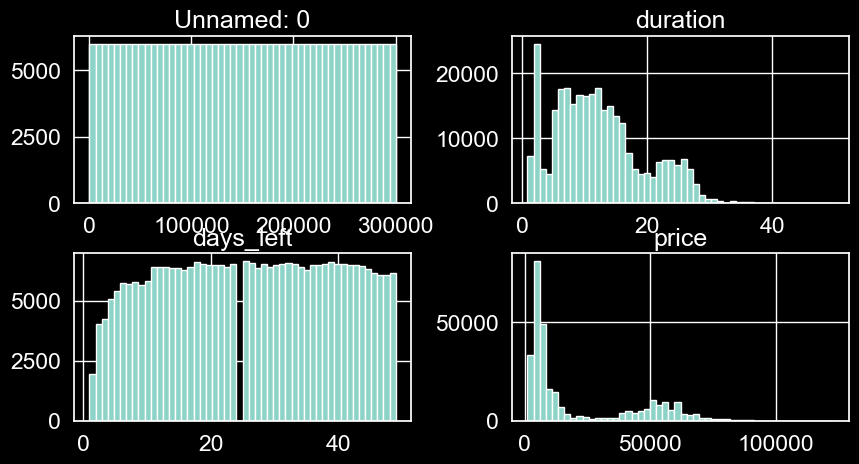

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import os
os.environ["JOBLIB_MULTIPROCESSING"] = "0"


# Carregar o dataset enviado pelo usuário
df = pd.read_csv(r'../Dados/Flight_Data.csv')

# Exibir as primeiras linhas do dataset para análise inicial
print("Informções iniciais do dataset:")
print(df.info())
print('-/-'*50)
print("Descrição do dataset para colunas numéricas:")
print(df.describe())
print('-/-'*50)
print("Tamanho do dataset, seu shape:")
print(df.shape)
print('-/-'*50)
print("Colunas de companhias aéreas do dataset:")
print(df["airline"].value_counts())
print('-/-'*50)
print("Colunas de classes de voos do dataset:")
print(df["class"].value_counts())

df.hist(bins=50, figsize=(10,5))
plt.show()

- airline: Nome da companhia aérea.
- flight: Código do voo.
- source_city: Cidade de origem.
- departure_time: Período do horário de partida.
- stops: Número de paradas.
- arrival_time: Período do horário de chegada.
- destination_city: Cidade de destino.
- class: Classe do assento (Economy ou Business).
- duration: Duração da viagem em horas.
- days_left: Dias restantes até o voo.
- price: Variável-alvo representando o preço da passagem, noso target

**O dataset parece estruturado e pronto para análise inicial.**

- A coluna "Unnamed: 0" parece ser um índice gerado automaticamente e pode ser removida.
- A variável-alvo "price" é contínua e adequada para o modelo de regressão linear.

Criamos uma cópia para iniciar a exploração e preparação do dataset, deixando o original, intacto e realizar a divisão entre o treino e o teste.

In [36]:
# Cópia do dataset original
df_exploracao = df.copy()

# Função para verificar a existência de uma coluna em um DataFrame
def verificar_coluna(df, coluna):
    if coluna in df.columns:
        print(f"A coluna '{coluna}' existe no DataFrame.")
        # Drop da coluna 'Unnamed: 0' e foi a única operação de limpeza realizada
        df_exploracao.drop('Unnamed: 0', axis=1, inplace=True)
    else:
        print(f"A coluna '{coluna}' não existe no DataFrame.")

# Verificar a existência da coluna 'Unnamed: 0' no DataFrame df_exploracao
verificar_coluna(df_exploracao, 'Unnamed: 0')

# Realizar o split do dataset em treino e teste
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Divisão do dataset em treino e teste
for train_index, test_index in split.split(df_exploracao, df_exploracao["class"]):
    strat_train_set = df_exploracao.loc[train_index]
    strat_test_set = df_exploracao.loc[test_index]

print(strat_train_set["class"].value_counts())
print(strat_test_set["class"].value_counts())

A coluna 'Unnamed: 0' existe no DataFrame.
class
Economy     165333
Business     74789
Name: count, dtype: int64
class
Economy     41333
Business    18698
Name: count, dtype: int64


## Verificando os atributos, Visualizações e Correlações

- Avaliamos o tipo de dado: categórico,
numérico ou texto.
- Identificamos a porcentagem de valores ausentes e verificamos a presença de ruídos, como outliers ou erros de arredondamento.
- Analisamos a utilidade de cada atributo para a tarefa, distinguindo quais variáveis são mais relevantes.
- Verificamos a distribuição (gaussiana, uniforme, etc.) das variáveis numéricas, o que é essencial para determinar a necessidade de transformações futuras.
- Histogramas ajudam a visualizar distribuições.
- Matriz de correlação identifica relações lineares entre variáveis numéricas, destacando potenciais redundâncias.
- Diagramas de dispersão (scatter plots) permitem analisar associações específicas.
- A visualização é crucial para identificar padrões que podem ser úteis na modelagem e para decidir quais atributos precisam de mais atenção.


Nessa etapa buscamos entender os atributos que estamos enfrentando.

In [37]:
# Nome dos atributos
atributos = strat_train_set.columns

# Tipo dos atributos
tipos = strat_train_set.dtypes

# % de valores ausentes
valores_ausentes = strat_train_set.isnull().mean() * 100

# Estatísticas descritivas para identificar possíveis ruídos
estatisticas = strat_train_set.describe(include='all')

valores_ausentes, estatisticas

(airline             0.0
 flight              0.0
 source_city         0.0
 departure_time      0.0
 stops               0.0
 arrival_time        0.0
 destination_city    0.0
 class               0.0
 duration            0.0
 days_left           0.0
 price               0.0
 dtype: float64,
         airline  flight source_city departure_time   stops arrival_time  \
 count    240122  240122      240122         240122  240122       240122   
 unique        6    1556           6              6       3            6   
 top     Vistara  UK-706       Delhi        Morning     one        Night   
 freq     102304    2623       49006          56947  200747        73227   
 mean        NaN     NaN         NaN            NaN     NaN          NaN   
 std         NaN     NaN         NaN            NaN     NaN          NaN   
 min         NaN     NaN         NaN            NaN     NaN          NaN   
 25%         NaN     NaN         NaN            NaN     NaN          NaN   
 50%         NaN     NaN

- Estatísticas Descritivas:

  - Duração (duration): Varia de 0.83 a 47.75 horas, com uma média de ~12.22 horas.
  - Dias restantes (days_left): Variam de 1 a 49, com uma média de ~26 dias.
  - Preço (price): Varia de ₹1105 a ₹117307, com uma mediana de ₹7425 e uma média de ~₹20885.
- Valores Ausentes:
  - Nenhuma coluna apresenta valores ausentes, indicando que os dados estão completos.
- Outliers:
  - O preço apresenta uma alta amplitude (máximo de ₹117307,00), sugerindo a presença de outliers ou uma distribuição enviesada.

as saídas foram interessantes, interpretando a saída do atributo price : 

- count: 240122.000000  
    - O número total de entradas na coluna price é 240122.
- unique: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- top: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- freq: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- mean: 20885.070826
    - A média dos valores na coluna price é aproximadamente 20885,07.
- std: 22691.892962
    - O desvio padrão dos valores na coluna price é aproximadamente 22691.89, indicando a dispersão dos valores em torno da média.
- min: 1105.000000
    - O valor mínimo na coluna price é 1105.
- 25%: 4783.000000
    - O primeiro quartil (25%) dos valores na coluna price é 4783, o que significa que 25% dos valores são menores ou iguais a 4783.
- 50%: 7425.000000
    - O valor mediano (50%) na coluna price é 7425, o que significa que metade dos valores são menores ou iguais a 7425.
- 75%: 42521.000000
    - O terceiro quartil (75%) dos valores na coluna price é 42521, o que significa que 75% dos valores são menores ou iguais a 42521.
- max: 117307.000000
    - O valor máximo na coluna price é 117307.

Embora a média esteja em torno de 20000, podemos ver aqui que a mediana é de aproximadamente 7500. Essa diferença é explicável pela presença de dois tickets diferentes: executiva e econômica. No segundo gráfico, podemos ver que a dispersão parece ser composta por duas curvas gaussianas.

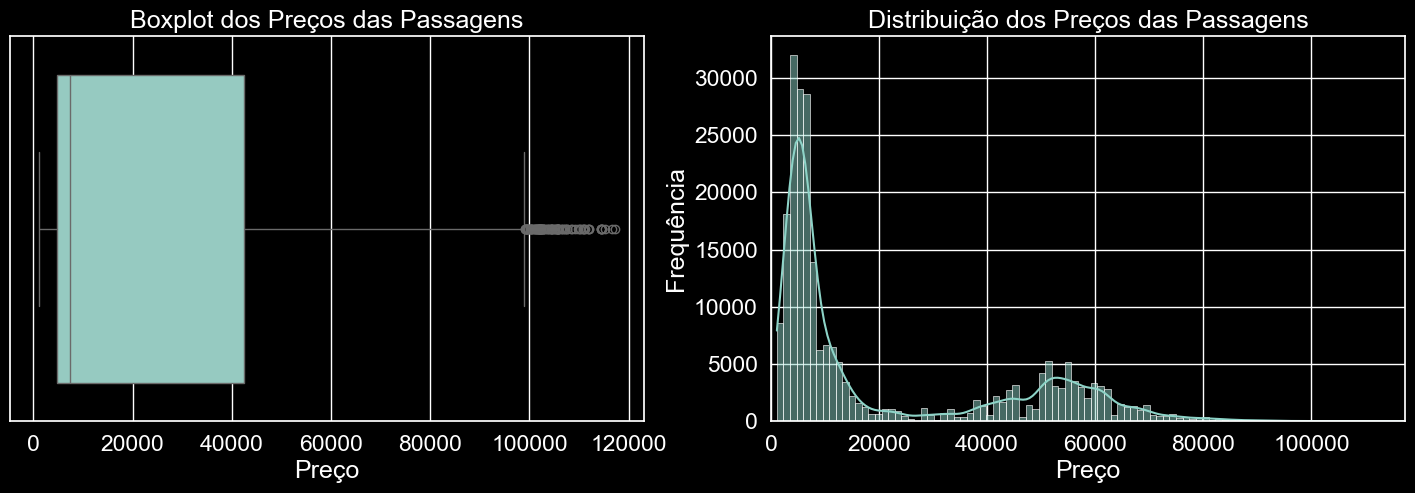

In [38]:
# Analisar a distribuição da coluna 'price'
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(strat_train_set['price'], kde=True)
plt.title('Distribuição dos Preços das Passagens')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.xlim(0, strat_train_set['price'].max())

plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = strat_train_set)
plt.title('Boxplot dos Preços das Passagens')
plt.xlabel('Preço')
plt.show()

em seguida pensamos em ter uma ideia de quais companhias aéreas estão presentes e sua quantidade de voos, agrupamos para melhor visualizar, no dataset como um todo

In [39]:
# Agrupamento de voos por companhia aérea
df1=strat_train_set.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

airline
Indigo       702
Air_India    218
GO_FIRST     204
SpiceJet     185
Vistara      133
AirAsia      114
Name: count, dtype: int64

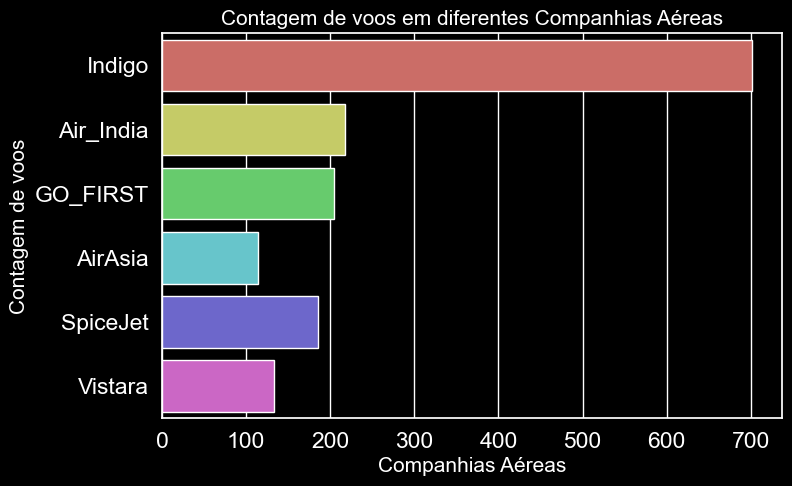

In [40]:
plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Contagem de voos em diferentes Companhias Aéreas',fontsize=15)
plt.xlabel('Companhias Aéreas',fontsize=15)
plt.ylabel('Contagem de voos',fontsize=15)
plt.show()

é percetível a grande quantidade de ocorrência em **Indigo**.

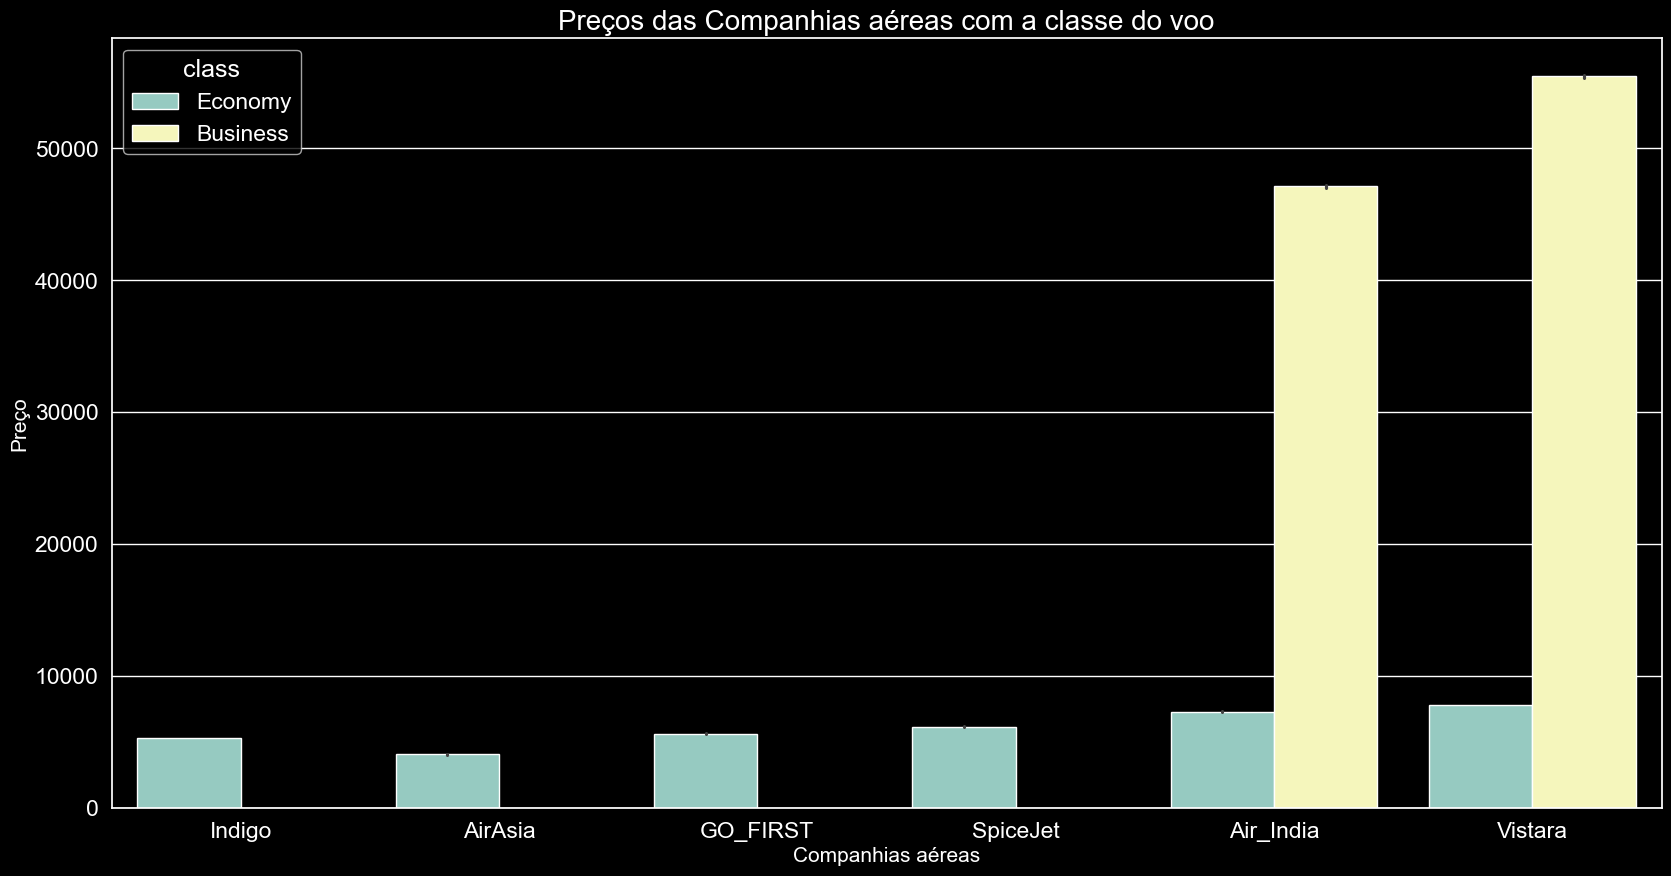

In [41]:
plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='airline', y='price', hue="class", data=strat_train_set.sort_values("price"))
barplot.set_title('Preços das Companhias aéreas com a classe do voo', fontsize=20)
barplot.set_xlabel('Companhias aéreas', fontsize=15)
barplot.set_ylabel('Preço', fontsize=15)
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_palette("husl")

depois, buscamos entender as classificações dos tipos de voos que temos, agrupando e trazendo a sua contagem de ocorrências

In [42]:
# Agrupamento do tipo de companhia e a classe do voo
df2=strat_train_set.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

class
Economy     1555
Business     295
Name: count, dtype: int64

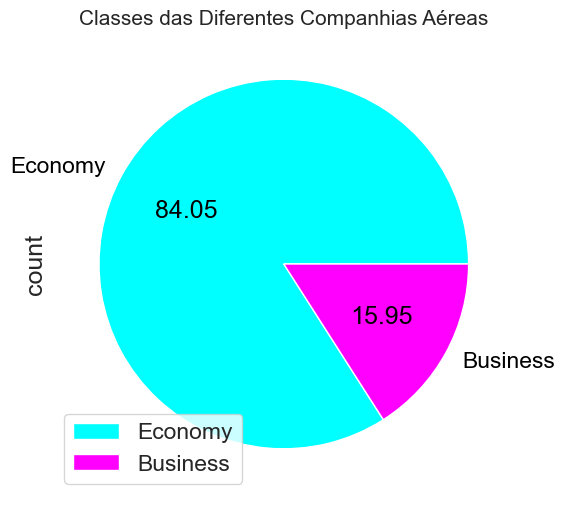

In [43]:
plt.figure(figsize=(8,6))
df2['class'].value_counts().plot(kind='pie',textprops={'color':'black'},autopct='%.2f',cmap='cool')
plt.title('Classes das Diferentes Companhias Aéreas',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

*O preço varia com as companhias aéreas?*

- Como podemos ver, a Vistara tem a faixa de preço máxima
- A Vistara e a Air_India Airlines têm o preço máximo quando comparadas a outras
- A SpiceJet, a AirAsia, a GO_First e a Indigo têm preços um tanto quanto iguais

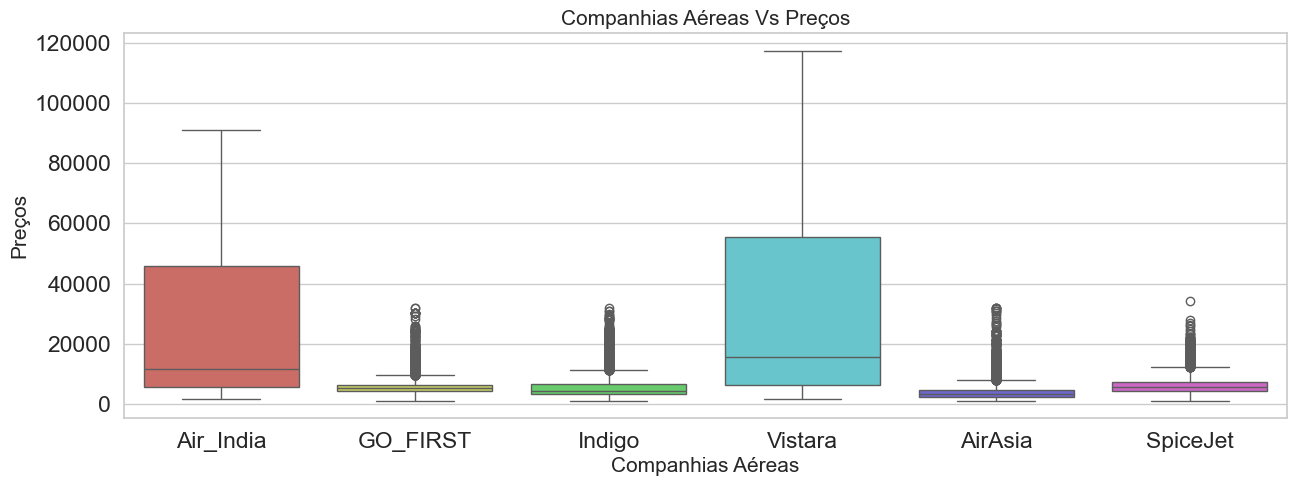

In [44]:
plt.figure(figsize=(15,5))
sns.boxplot(x=strat_train_set['airline'],y=strat_train_set['price'],palette='hls')
plt.title('Companhias Aéreas Vs Preços',fontsize=15)
plt.xlabel('Companhias Aéreas',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Variação entre o preço da passagem, varia entre as classes?*

- O preço do bilhete é máximo para a classe executiva quando comparado à classe econômica

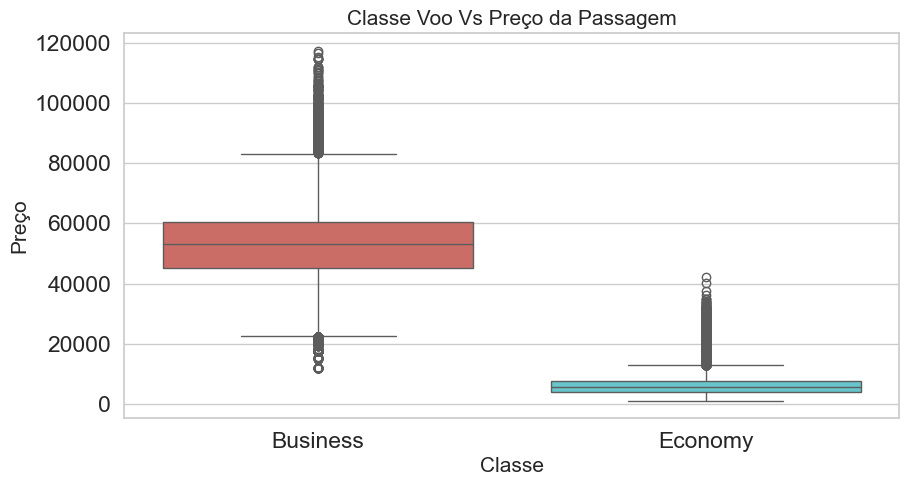

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x='class',y='price',data=strat_train_set,palette='hls')
plt.title('Classe Voo Vs Preço da Passagem',fontsize=15)
plt.xlabel('Classe',fontsize=15)
plt.ylabel('Preço',fontsize=15)
plt.show()

*Como o preço do bilhete varia com o número de paradas de um voo?*

- Voos com uma parada têm preço máximo de bilhete

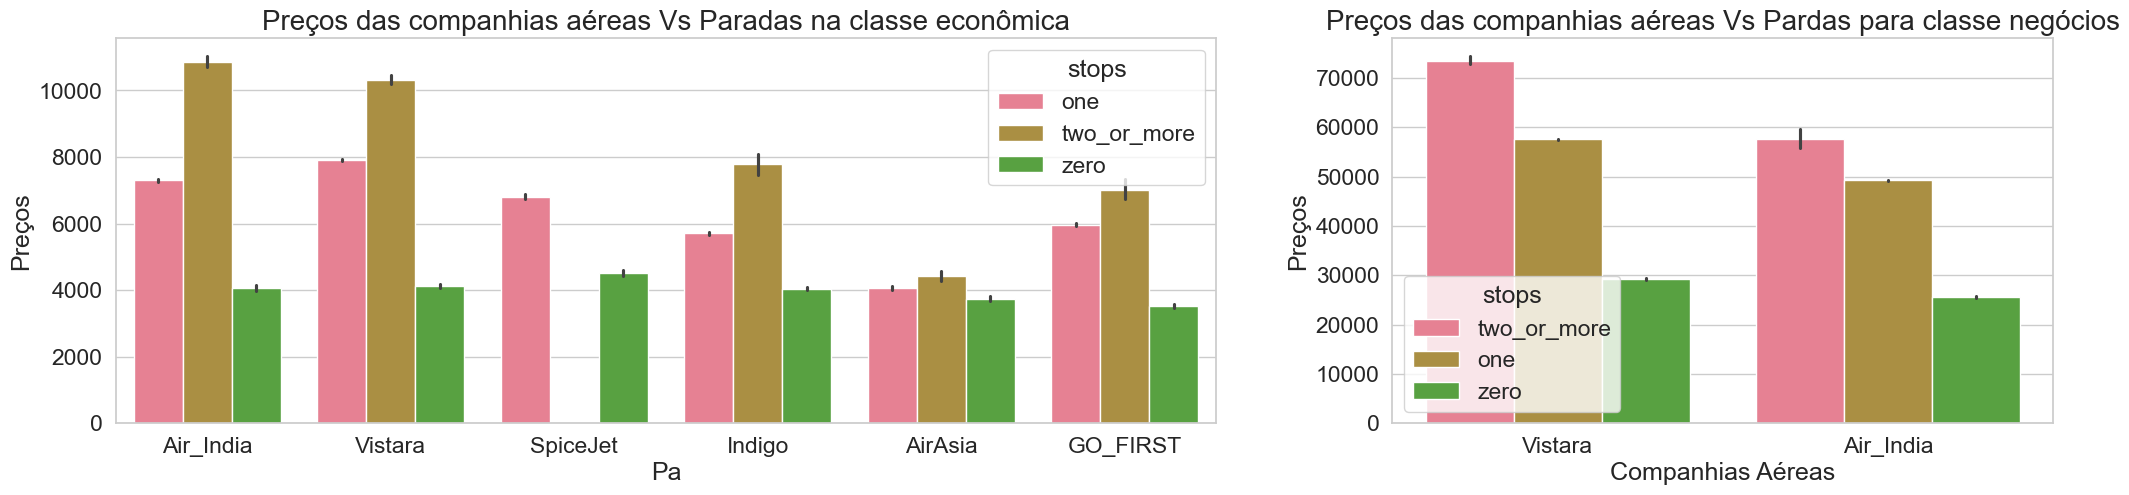

In [46]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))

sns.barplot(y="price", x="airline", hue="stops", data=strat_train_set.loc[strat_train_set["class"] == 'Economy'].sort_values("price", ascending=False), ax=axs[0])
axs[0].set_title("Preços das companhias aéreas Vs Paradas na classe econômica", fontsize=20)
axs[0].set_xlabel("Pa")
axs[0].set_ylabel("Preços")

sns.barplot(y="price", x="airline", hue="stops", data=strat_train_set.loc[strat_train_set["class"] == 'Business'].sort_values("price", ascending=False), ax=axs[1])
axs[1].set_title("Preços das companhias aéreas Vs Pardas para classe negócios", fontsize=20)
axs[1].set_xlabel("Companhias Aéreas")
axs[1].set_ylabel("Preços")

plt.show()

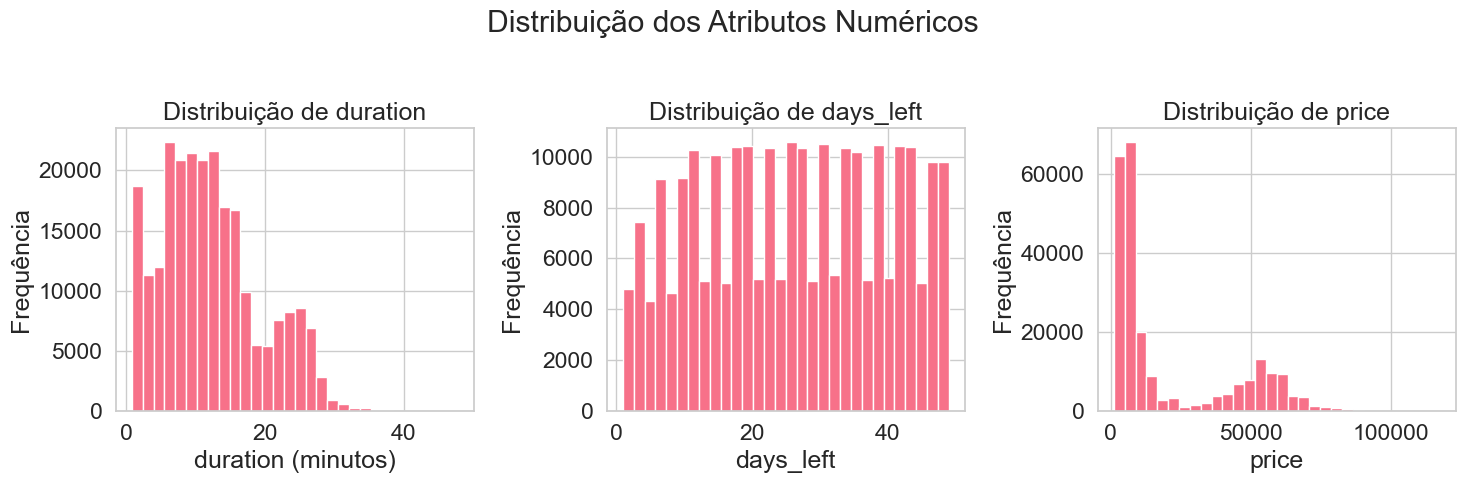

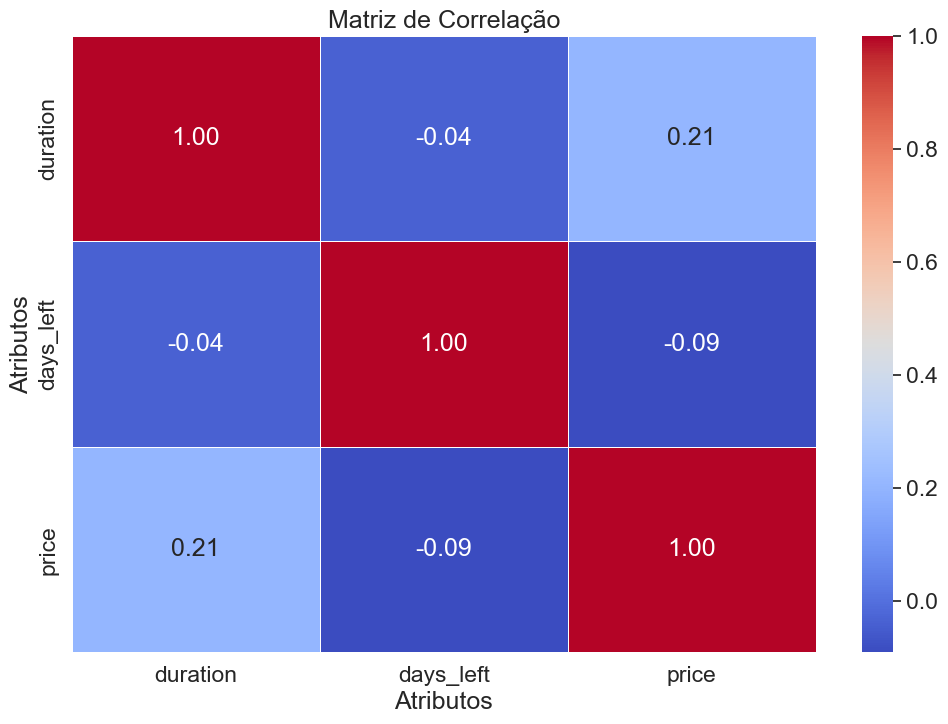

Pares de atributos com alta correlação:
           duration  days_left  price
duration        1.0        NaN    NaN
days_left       NaN        1.0    NaN
price           NaN        NaN    1.0


In [47]:
# Selecionar apenas as colunas numéricas relevantes
df_numerico = strat_train_set[['duration', 'days_left', 'price']]

# Visualizar a distribuição dos dados para cada atributo numérico
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_numerico['duration'].hist(bins=30, ax=axes[0])
axes[0].set_title('Distribuição de duration')
axes[0].set_xlabel('duration (minutos)')
axes[0].set_ylabel('Frequência')

df_numerico['days_left'].hist(bins=30, ax=axes[1])
axes[1].set_title('Distribuição de days_left')
axes[1].set_xlabel('days_left')
axes[1].set_ylabel('Frequência')

df_numerico['price'].hist(bins=30, ax=axes[2])
axes[2].set_title('Distribuição de price')
axes[2].set_xlabel('price')
axes[2].set_ylabel('Frequência')

plt.suptitle('Distribuição dos Atributos Numéricos')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualizar a correlação entre os atributos numéricos
correlacao = df_numerico.corr()
plt.figure(figsize=(12, 8))
plt.title('Matriz de Correlação')
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xlabel('Atributos')
plt.ylabel('Atributos')
plt.show()

# Identificar pares de atributos com alta correlação (acima de 0.8 ou abaixo de -0.8)
alta_correlacao = correlacao[(correlacao > 0.8) | (correlacao < -0.8)]
print("Pares de atributos com alta correlação:")
print(alta_correlacao)

Embora a média esteja em torno de 20000, podemos ver aqui que a mediana é de aproximadamente 7500. Essa diferença é explicável pela presença de dois tickets diferentes: executiva e econômica. No segundo gráfico, podemos ver que a dispersão parece ser composta por duas curvas gaussianas.

*Como o preço do bilhete varia com o número de paradas de um voo?*

- Voos com uma parada têm preço máximo de bilhete

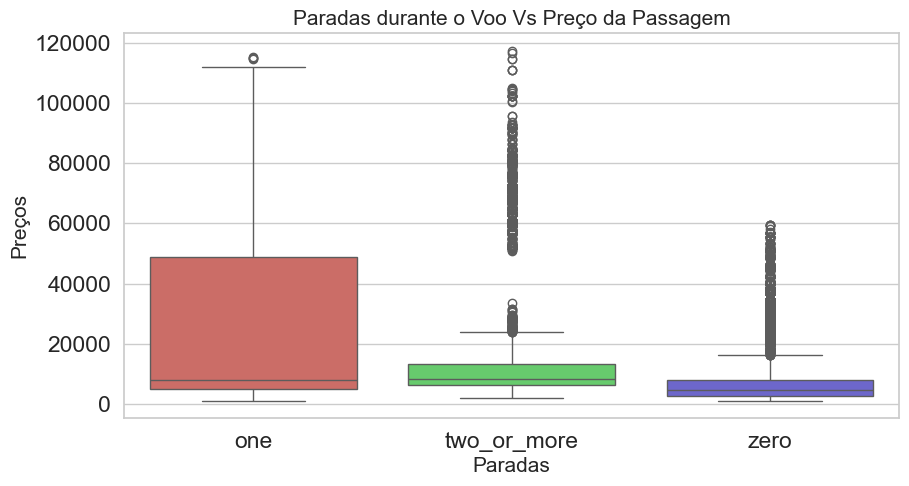

In [48]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=strat_train_set,palette='hls')
plt.title('Paradas durante o Voo Vs Preço da Passagem',fontsize=15)
plt.xlabel('Paradas',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Número total de voos de uma cidade para outra*

In [49]:
# Agrupa os voos por cidade de origem e destino
grouped_df = strat_train_set.groupby(['flight','source_city','destination_city','airline','class'], as_index=False).count()
# Agrupa os voos por cidade de origem e destino e conta o número de voos
result = grouped_df.groupby(['source_city','destination_city'], as_index=False)['flight'].count().head(10)
print(result)

  source_city destination_city  flight
0   Bangalore          Chennai     106
1   Bangalore            Delhi     226
2   Bangalore        Hyderabad     132
3   Bangalore          Kolkata     169
4   Bangalore           Mumbai     175
5     Chennai        Bangalore      69
6     Chennai            Delhi     105
7     Chennai        Hyderabad      81
8     Chennai          Kolkata     110
9     Chennai           Mumbai      94


*Preço médio de diferentes companhias aéreas da cidade de origem para a cidade de destino*

In [50]:
# Agrupa os voos por cidade de origem e destino e calcula a média dos preços
strat_train_set.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2052.535714
1,AirAsia,Bangalore,Delhi,4783.551447
2,AirAsia,Bangalore,Hyderabad,2968.260000
3,AirAsia,Bangalore,Kolkata,4376.965517
4,AirAsia,Bangalore,Mumbai,3271.393281
5,AirAsia,Chennai,Bangalore,1878.466019
6,AirAsia,Chennai,Delhi,3635.407801
7,AirAsia,Chennai,Hyderabad,2072.551402
8,AirAsia,Chennai,Kolkata,3699.811245
9,AirAsia,Chennai,Mumbai,2649.022222


*Como o preço varia com a duração do voo com base na classe?*

- Com o aumento da duração, o preço da passagem também aumenta nas classes Economy e Business

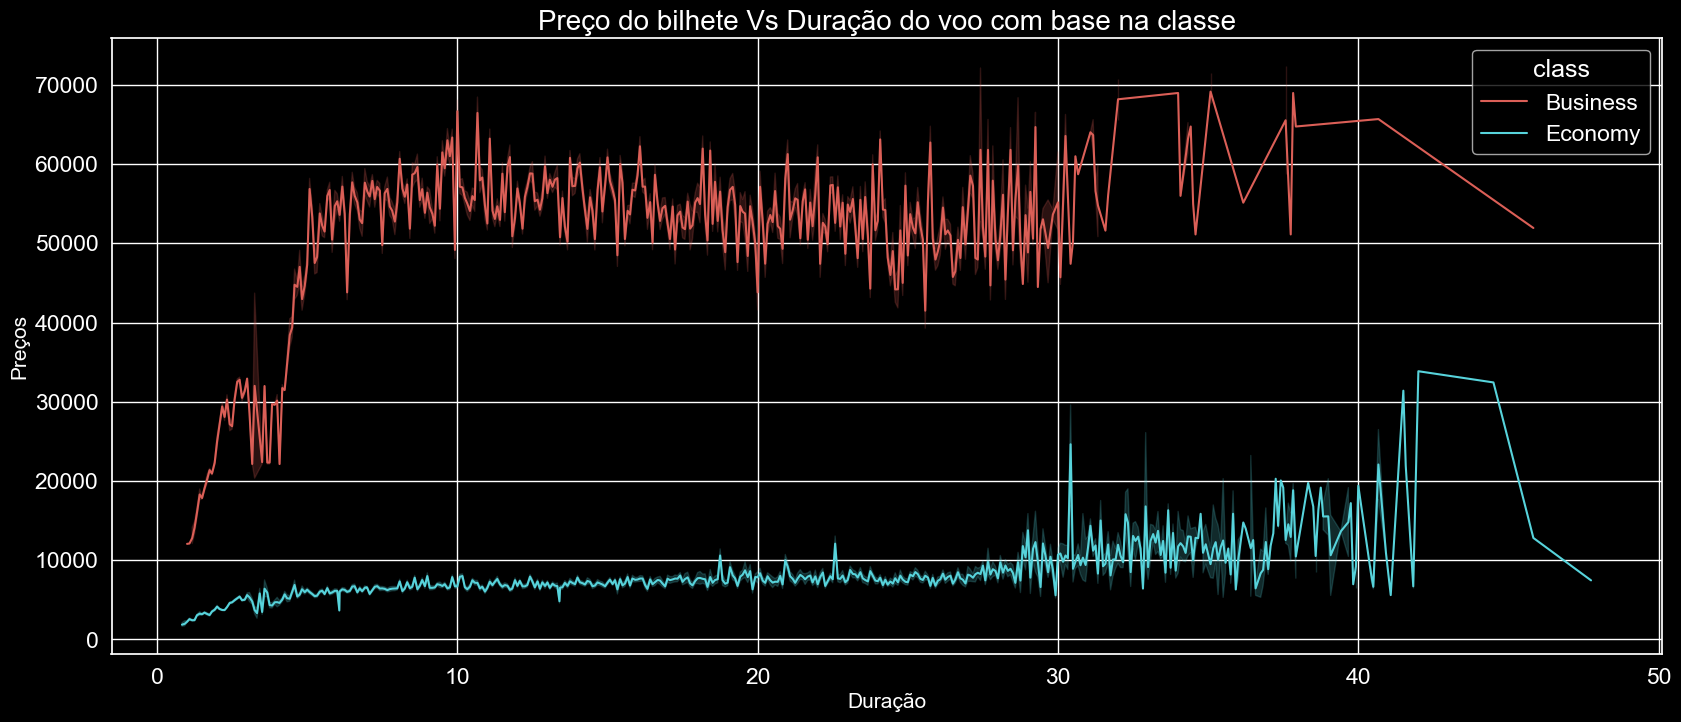

In [51]:
plt.style.use('dark_background')
plt.figure(figsize=(20,8))
sns.lineplot(data=strat_train_set,x='duration',y='price',hue='class',palette='hls')
plt.title('Preço do bilhete Vs Duração do voo com base na classe',fontsize=20)
plt.xlabel('Duração',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Como o preço muda com a mudança na cidade de origem e na cidade de destino?*
1. Cidade de origem x preço do bilhete

- O preço do bilhete é maior para os voos cuja cidade de origem é Calcutá
- O preço do bilhete é quase igual para voos com cidades de origem como Mumbai e Chennai, Hyderabad e Bangalore
- O preço do bilhete é menor para voos com cidade de origem como Déli
2. Cidade de destino x preço do bilhete
- O preço do bilhete é maior para voos cuja cidade de destino é Calcutá e Chennai
- O preço do bilhete é quase igual para voos com cidades de destino como Mumbai e Bangalore
- O preço do bilhete é menor para voos com cidade de destino como Déli

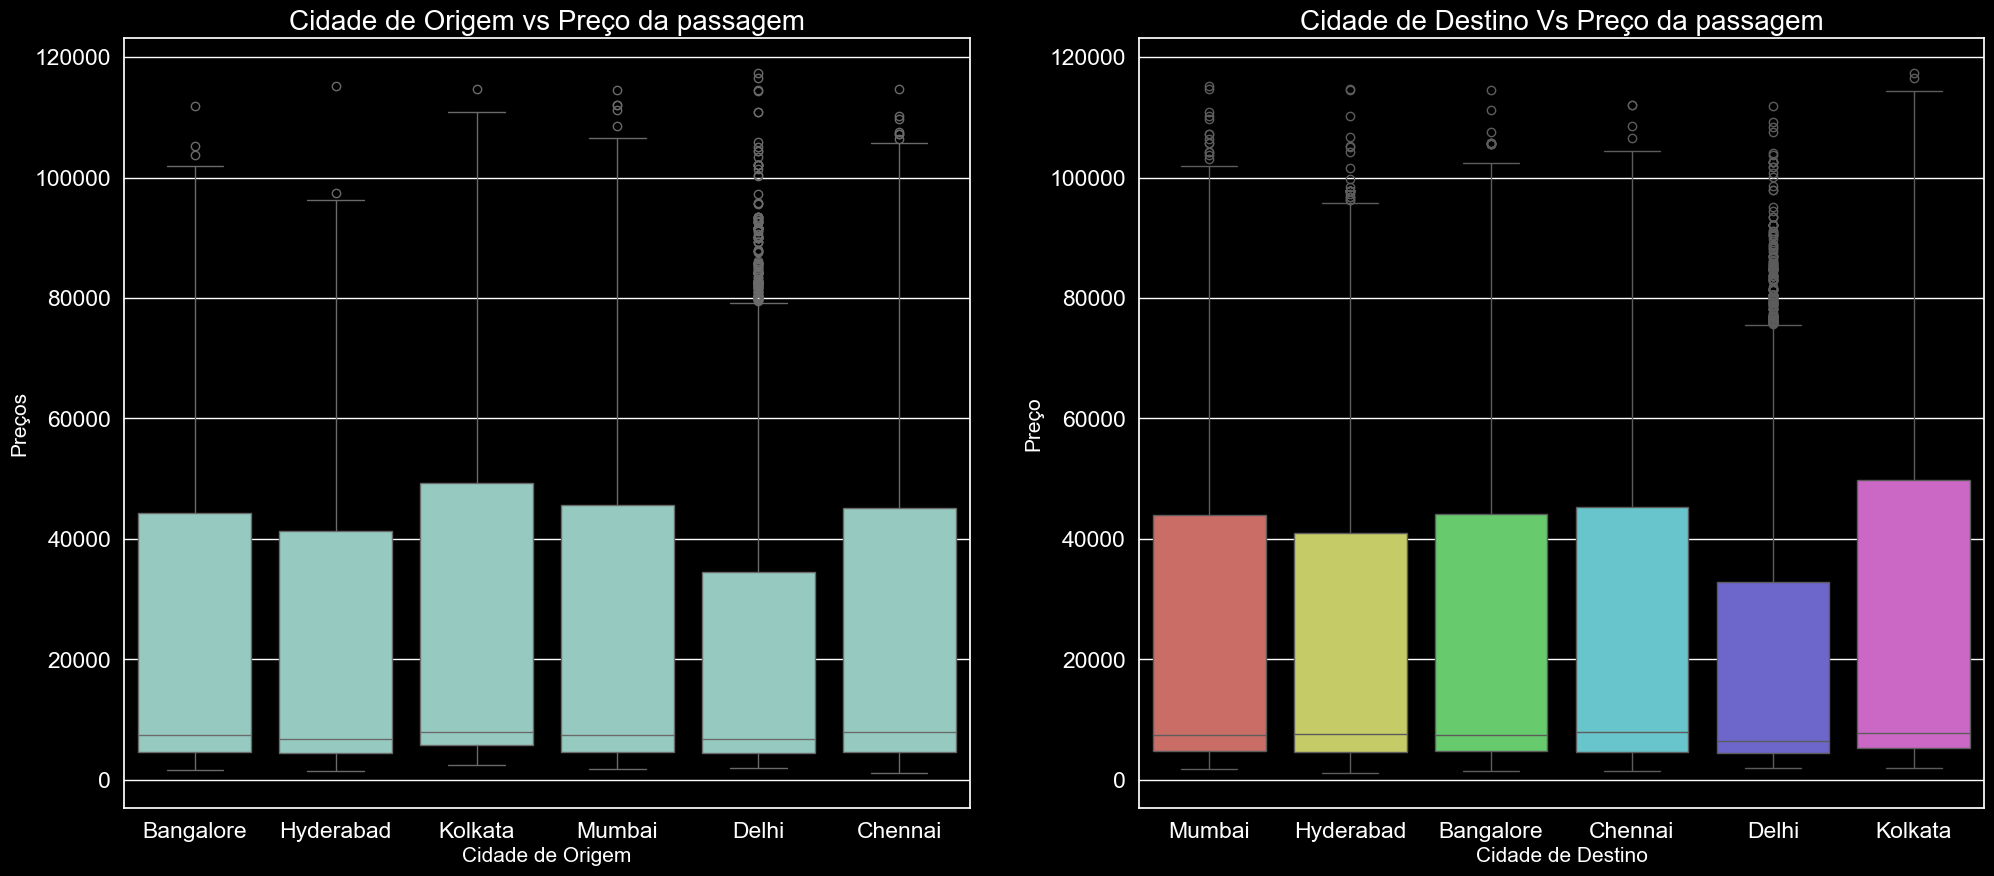

In [52]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=strat_train_set)
plt.title('Cidade de Origem vs Preço da passagem',fontsize=20)
plt.xlabel('Cidade de Origem',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=strat_train_set,palette='hls')
plt.title('Cidade de Destino Vs Preço da passagem',fontsize=20)
plt.xlabel('Cidade de Destino',fontsize=15)
plt.ylabel('Preço',fontsize=15)
plt.show()

## Transformações promissoras

- Normalização/Escalonamento: Ajustar os valores numéricos para uma escala comum, geralmente entre 0 e 1, ou para uma distribuição normal. Isso é útil para algoritmos que são sensíveis à escala dos dados, como regressão linear e redes neurais.
- Codificação de Variáveis Categóricas: Converter variáveis categóricas em uma forma numérica que pode ser usada pelos algoritmos de aprendizado de máquina. Métodos comuns incluem One-Hot Encoding e Label Encoding.
- Transformações Logarítmicas: Aplicar uma transformação logarítmica para reduzir a assimetria dos dados

## Dados-extras

Exemplo de dados extras que podem ser úteis:
- Dados demográficos (idade, gênero, localização)
- Dados econômicos (renda, emprego)
- Dados temporais (sazonalidade, tendências)
- Dados de comportamento (histórico de compras, interações)

In [53]:
dados_extras = [
    'Idade',
    'Gênero',
    'Localização',
    'Renda',
    'Emprego',
    'Sazonalidade',
    'Tendências',
    'Histórico de Compras',
    'Interações'
]

# Exibir a lista de dados extras
print("Dados extras que podem ser úteis para a análise:")
for dado in dados_extras:
    print(f"- {dado}")

Dados extras que podem ser úteis para a análise:
- Idade
- Gênero
- Localização
- Renda
- Emprego
- Sazonalidade
- Tendências
- Histórico de Compras
- Interações


# Preparação

Os dados são transformados para se tornarem utilizáveis pelos modelos.

- Limpeza de dados: Lidamos com valores ausentes preenchendo-os com estratégias como a mediana, média ou moda. Também podemos remover outliers, especialmente se eles distorcem os resultados.
- Seleção de características: Excluímos atributos irrelevantes ou redundantes para simplificar o modelo e melhorar a eficiência.
- Feature engineering: Transformamos variáveis para melhorar seu impacto no modelo, como normalizar distribuições ou criar novas colunas a partir de dados existentes.
- Escalonamento: Normalizamos ou padronizamos variáveis numéricas para garantir que todas estejam na mesma escala, essencial para algoritmos que dependem de distâncias ou gradientes.

Para essa fase de preparação, temos a pergunta, **O que mais influencia nos preços das passagens?**

Pensando nisso, pensamos em uma forma de pré-processar os dados e levá-los para os modelos:

- Codificamos a variável stops para valores numéricos (0, 1, 2) e a variável class para valores numéricos (0, 1) 
- Criação de variáveis dummy:
    - Para as variáveis categóricas airline, source_city, destination_city, departure_time e arrival_time, foram criadas variáveis dummy. Isso significa que cada categoria dessas variáveis foi transformada em uma coluna binária (0 ou 1), indicando a presença ou ausência daquela categoria. Isso é necessário porque muitos algoritmos de aprendizado de máquina não podem trabalhar diretamente com dados categóricos.

In [54]:
def preprocessing(df):
    # Transformar os dados categóricos em numéricos    
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    # Normalização dos dados
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    
    # Drop das colunas originais
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df

In [55]:
df_preprocessado = preprocessing(df_exploracao)

print(df_preprocessado.head())

   stops  class  duration  days_left  price  airline_Air_India  \
0      0      0      2.17          1   5953              False   
1      0      0      2.33          1   5953              False   
2      0      0      2.17          1   5956              False   
3      0      0      2.25          1   5955              False   
4      0      0      2.33          1   5955              False   

   airline_GO_FIRST  airline_Indigo  airline_SpiceJet  airline_Vistara  \
0             False           False              True            False   
1             False           False              True            False   
2             False           False             False            False   
3             False           False             False             True   
4             False           False             False             True   

   source_city_Chennai  source_city_Delhi  source_city_Hyderabad  \
0                False               True                  False   
1                False

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Definição dos atributos numéricos, categóricos e ordinais
num_attribs = ["duration", "days_left"]
cat_attribs = ["airline", "source_city", "destination_city", "departure_time", "arrival_time"]
ord_attribs = ["stops", "class"]

# Definindo as categorias para o OrdinalEncoder na ordem correta
ordinal_categories = [
    ['zero', 'one', 'two_or_more'],  # Ordem para "stops"
    ['Economy', 'Business']          # Ordem para "class"
]

# Pipeline com OrdinalEncoder configurado
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ("ord", OrdinalEncoder(categories=ordinal_categories), ord_attribs),
])

# Aplicar o pipeline
strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set)

strat_train_set_prepared_df = pd.DataFrame(
    strat_train_set_prepared.toarray(),  # Converte a matriz esparsa em um array denso
    columns=full_pipeline.get_feature_names_out()  # Obtém os nomes das colunas geradas pelo pipeline
)

print(strat_train_set.tail())
print('-/-'*50)
# Exibir as primeiras linhas
print(strat_train_set_prepared_df.tail())

          airline  flight source_city departure_time stops arrival_time  \
70331   Air_India  AI-442      Mumbai      Afternoon   one      Evening   
136233    Vistara  UK-772     Kolkata        Morning   one      Evening   
275362    Vistara  UK-880   Hyderabad      Afternoon  zero    Afternoon   
273423    Vistara  UK-738     Kolkata        Evening   one        Night   
118046    Vistara  UK-814   Bangalore          Night   one      Morning   

       destination_city     class  duration  days_left  price  
70331         Hyderabad   Economy     27.42          1  10724  
136233        Bangalore   Economy      8.83          7  12880  
275362            Delhi  Business      2.25         14  24234  
273423          Chennai  Business     25.50         20  55983  
118046          Chennai   Economy     12.75         31   6161  
-/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/-
        num__d

Para visualizar a importância linear de cada variável no alvo, traçamos uma matriz de correlação.

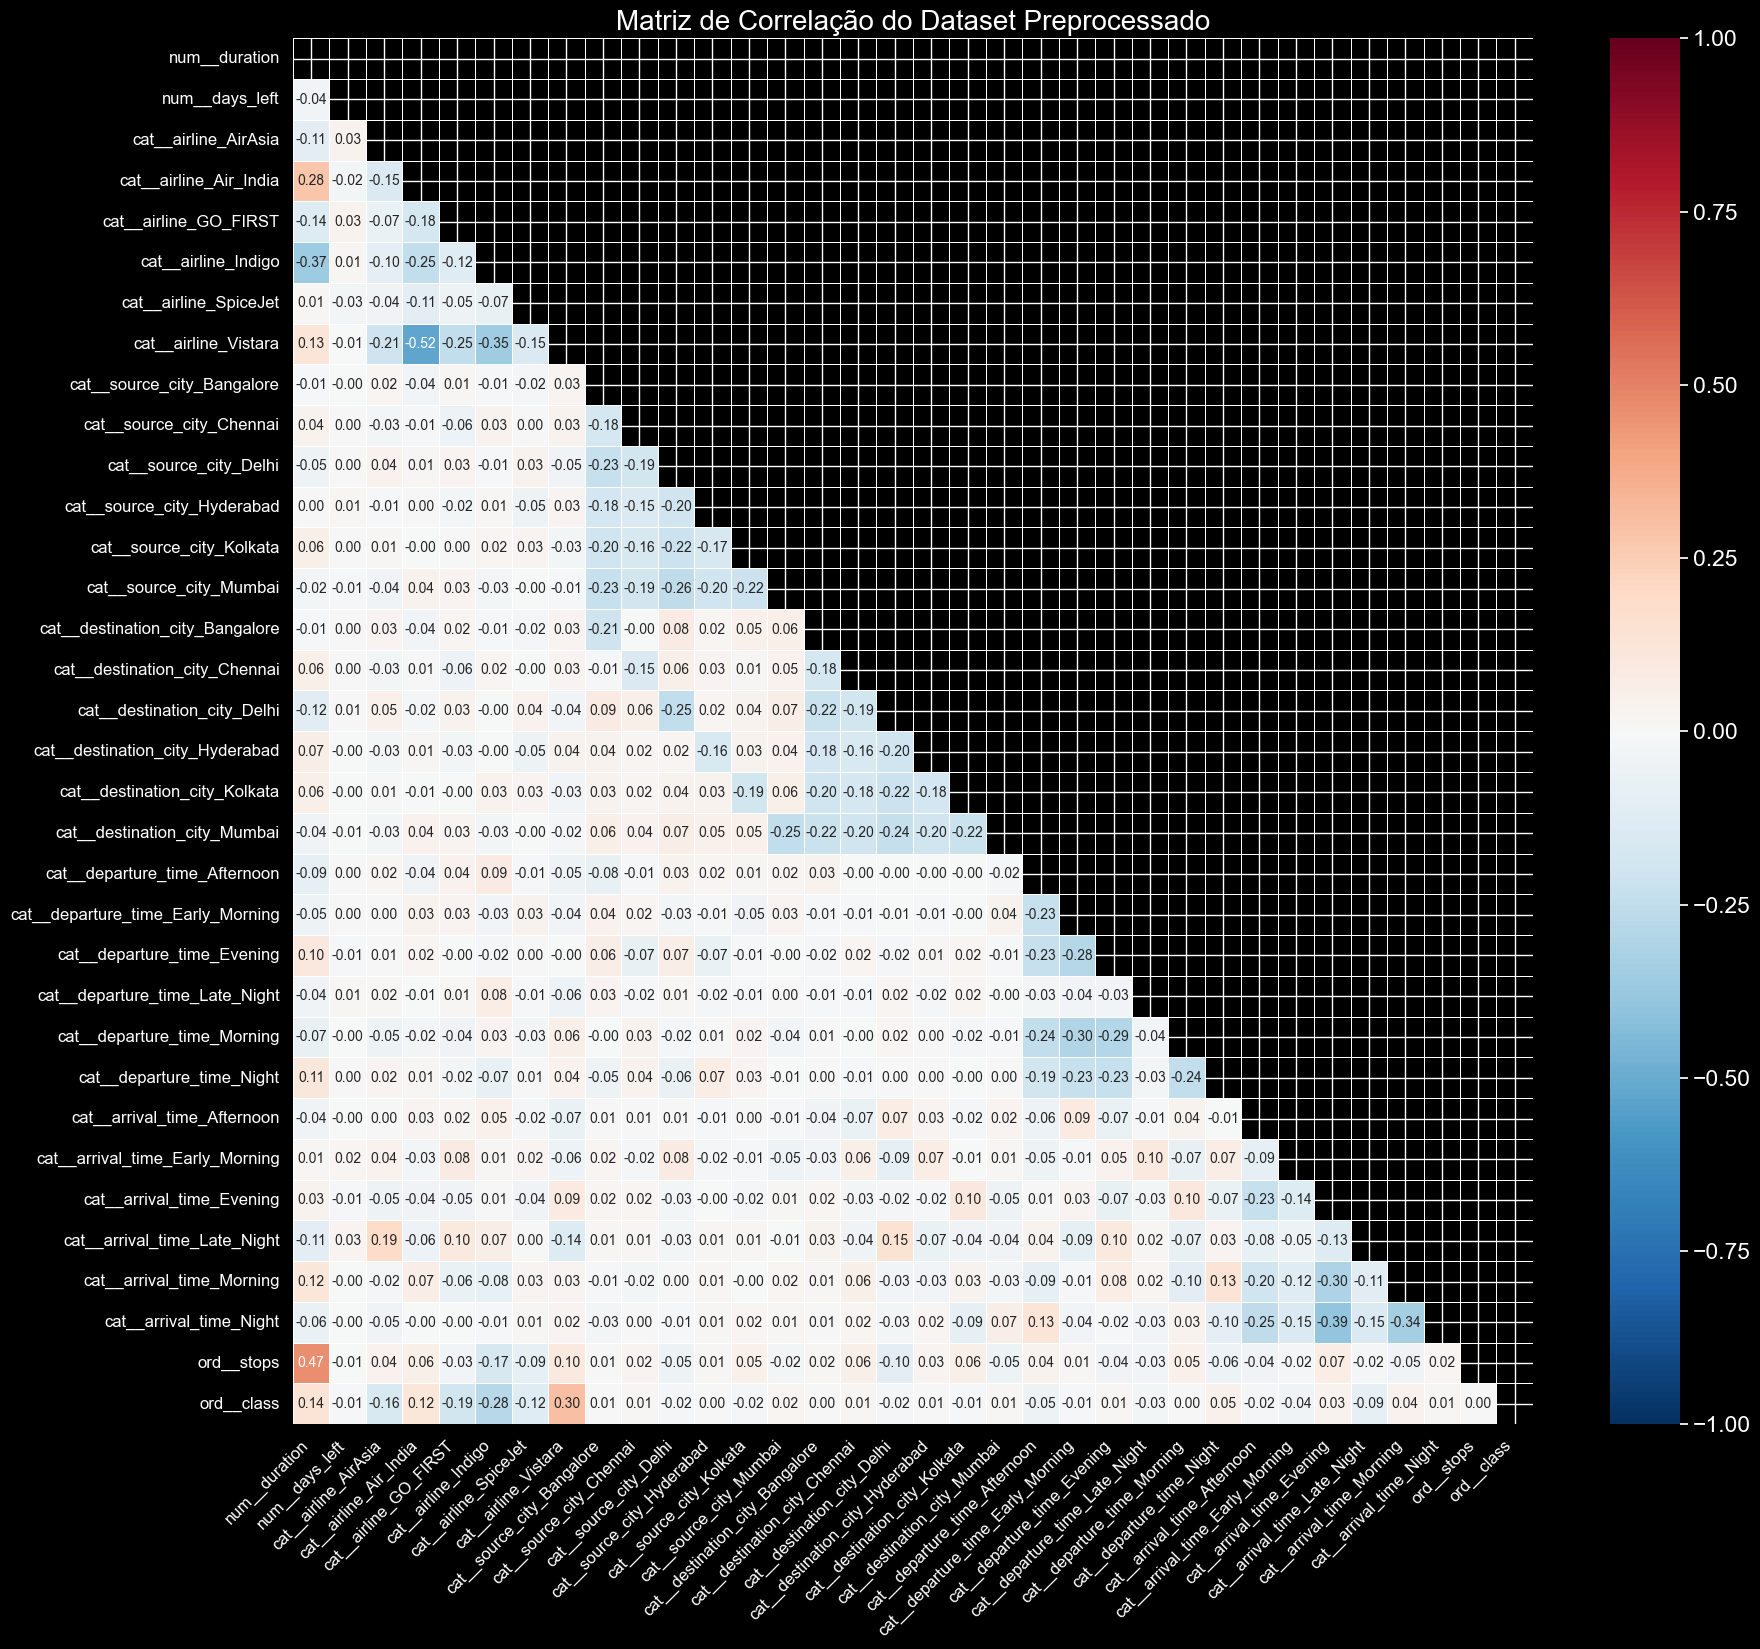

In [58]:
# Exibir as primeiras linhas do dataset preprocessado
mask = np.triu(np.ones_like(strat_train_set_prepared_df.corr(), dtype=bool))

plt.figure(figsize = (20,18))
# Plotando a matriz de correlação com melhor visualização
sns.heatmap(strat_train_set_prepared_df.corr(), mask=mask, annot=True, vmin=-1.0, vmax=1.0, center=0, cmap='RdBu_r', linewidths=0.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Matriz de Correlação do Dataset Preprocessado', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Porém, a correlação é uma boa métrica para relacionamento linear, mas não destaca os não lineares. Para isso, usamos informações mútuas, por isso usamos a Medição de Informação Mútua (MI) que ajuda a identificar quais variáveis independentes (features) têm maior relevância ou dependência com a variável dependente (target). Isso é útil para seleção de features, onde queremos escolher as variáveis mais informativas para o modelo. podendo ela capturar tanto relações lineares quanto não lineares entre as variáveis.

Para interpretá-la:

- A MI é sempre não negativa e varia de 0 a ∞.
- MI = 0: Indica que não há dependência entre a feature e o target. A feature não fornece nenhuma informação sobre o target.
- MI > 0: Indica que há alguma dependência entre a feature e o target. Quanto maior o valor, maior a dependência.

In [59]:
def make_mi_scores(X, y):
    # Fizemos uma cópia do DataFrame para evitar alterações indesejadas
    X = X.copy()
    # Transformar os dados categóricos em category e depois em numéricos com o factorize
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # Criamos uma lista booleana para identificar os atributos discretos
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    # Calculamos os scores de MI
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    # Transformamos os scores em uma série do pandas
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [61]:
# Fizemos uma cópia dos dados preprocessados e do target
X = df_preprocessado.copy()
y = X.pop("price")

mi_scores = make_mi_scores(X, y)

In [62]:
print(mi_scores.sort_values(ascending=False))

duration                        2.415277
class                           0.618093
airline_Vistara                 0.517385
days_left                       0.477406
source_city_Delhi               0.430462
source_city_Mumbai              0.428634
airline_Air_India               0.403297
stops                           0.392738
destination_city_Delhi          0.387216
destination_city_Mumbai         0.382443
source_city_Kolkata             0.360909
source_city_Hyderabad           0.346552
destination_city_Kolkata        0.339796
source_city_Chennai             0.325926
destination_city_Hyderabad      0.318186
destination_city_Chennai        0.302343
airline_Indigo                  0.286906
airline_GO_FIRST                0.202483
arrival_time_Evening            0.127975
arrival_time_Night              0.106256
departure_time_Evening          0.104635
arrival_time_Morning            0.102338
departure_time_Morning          0.092502
departure_time_Early_Morning    0.089224
airline_SpiceJet

**Features Mais Informativas:**

- **duration (2.415277):** A duração do voo é a feature mais informativa, indicando que tem a maior dependência com o preço das passagens.
- **class (0.618093):** A classe do assento (Economy ou Business) também é altamente informativa.
- **airline_Vistara (0.517385):** A companhia aérea Vistara tem uma influência significativa no preço das passagens.
- **days_left (0.477406):** O número de dias restantes até o voo também é uma feature importante.
- **source_city_Delhi (0.430462) e source_city_Mumbai (0.428634):** As cidades de origem Delhi e Mumbai são relevantes para a determinação do preço.

**Features Moderadamente Informativas:**

- **airline_Air_India (0.403297):** A companhia aérea Air India tem uma influência moderada.
- **stops (0.392738):** O número de paradas durante o voo também é relevante.
- **destination_city_Delhi (0.387216) e destination_city_Mumbai (0.382443):** As cidades de destino Delhi e Mumbai têm uma influência moderada.

**Features Menos Informativas:**

- **departure_time_Late_Night (0.013410):** O horário de partida tarde da noite é a feature menos informativa.
- **arrival_time_Late_Night (0.070387):** O horário de chegada tarde da noite também tem pouca influência.

In [63]:
# Selecionar as top 10 features mais informativas
top_10_features = mi_scores.head(10)
print("Top 10 features mais informativas:\n", top_10_features)

# Filtrar o DataFrame original para incluir apenas essas features
selected_features = top_10_features.index
X_selected = X[selected_features]

Top 10 features mais informativas:
 duration                   2.415277
class                      0.618093
airline_Vistara            0.517385
days_left                  0.477406
source_city_Delhi          0.430462
source_city_Mumbai         0.428634
airline_Air_India          0.403297
stops                      0.392738
destination_city_Delhi     0.387216
destination_city_Mumbai    0.382443
Name: MI Scores, dtype: float64


# Pre-seleção de modelos promissores

Nessa parte, selecionamos alguns modelos de ML para comparar seus resultados.

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import numpy as np


**Linear Regression**
A Linear Regression é um modelo de aprendizado supervisionado que assume uma relação linear entre a variável dependente (target) e uma ou mais variáveis independentes (features). A função de custo da regressão linear é minimizar a soma dos quadrados dos resíduos (diferença entre os valores observados e previstos). É simples e interpretável, mas pode não capturar relações complexas entre as variáveis.

**Random Forest Regressor**
O Random Forest Regressor é um modelo de aprendizado de máquina que utiliza uma coleção de árvores de decisão (floresta) para realizar previsões de regressão. Cada árvore na floresta é construída a partir de uma amostra aleatória dos dados de treinamento e faz previsões independentes. A previsão final do modelo é a média das previsões de todas as árvores. Esse método ajuda a reduzir o overfitting e melhora a precisão do modelo, pois combina múltiplas árvores de decisão para obter uma previsão mais robusta.

**Decision Tree**
A Decision Tree é um modelo de aprendizado supervisionado que pode ser usado tanto para classificação quanto para regressão. Ele divide os dados em subconjuntos baseados em valores de atributos, criando uma estrutura em forma de árvore onde cada nó interno representa uma "pergunta" sobre um atributo e cada folha representa um resultado (ou valor de previsão). A árvore é construída de forma recursiva, selecionando o atributo que melhor divide os dados em cada etapa, geralmente usando métricas como Gini impurity ou entropia para classificação, e variância para regressão.

**K-Nearest Neighbors Regressor (KNN Regressor)**
O K-Nearest Neighbors Regressor é um modelo de aprendizado baseado em instâncias que faz previsões de regressão com base nos k exemplos mais próximos no espaço de características. Para prever o valor de uma nova amostra, o modelo calcula a média dos valores das k amostras mais próximas (vizinhos) no conjunto de treinamento. A proximidade é geralmente medida usando a distância Euclidiana. O KNN é simples e intuitivo, mas pode ser computacionalmente caro para grandes conjuntos de dados e sensível à escolha de k e à escala dos dados.

**Ridge Regression**
A Ridge Regression é uma técnica de regressão linear que inclui uma penalização (regularização) L2 para reduzir o overfitting. A função de custo da regressão Ridge adiciona um termo de penalização proporcional ao quadrado dos coeficientes do modelo. Isso força os coeficientes a serem menores, o que pode melhorar a generalização do modelo em dados não vistos. A regularização é controlada por um hiperparâmetro lambda (ou alpha), que determina a força da penalização.

**Support Vector Regression (SVR)**
O Support Vector Regression (SVR) é uma extensão do Support Vector Machine (SVM) para problemas de regressão. O SVR tenta encontrar um hiperplano que tenha a maior margem possível e que esteja dentro de uma tolerância especificada (epsilon) dos pontos de dados. Em outras palavras, ele busca um equilíbrio entre a complexidade do modelo e a precisão das previsões, permitindo que alguns pontos de dados estejam fora da margem, mas penalizando-os. O SVR pode usar diferentes tipos de kernels (linear, polinomial, RBF) para lidar com dados não lineares.

**Principal Component Analysis (PCA)**
O Principal Component Analysis (PCA) é uma técnica de redução de dimensionalidade que transforma os dados originais em um novo conjunto de variáveis ortogonais chamadas componentes principais. Essas componentes principais são ordenadas de forma que a primeira componente captura a maior variância dos dados, a segunda componente captura a segunda maior variância, e assim por diante. O PCA é útil para reduzir a complexidade dos dados, remover redundâncias e melhorar a eficiência computacional dos modelos de aprendizado de máquina. No contexto dos modelos mencionados, o PCA pode ser usado para reduzir a dimensionalidade dos dados antes de aplicar os modelos, ajudando a melhorar a performance e a evitar o overfitting.

dividimos o conjunto de dados em treino e teste

In [65]:
# Divisão dos dados em treino e teste usandos a cópia dos dados preprocessados
print(df_exploracao.columns)
X = df_exploracao.drop(['price'], axis=1)
y = df_exploracao["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')
(240122, 10) (60031, 10) (240122,) (60031,)


In [66]:
# Imprimir os nomes das colunas do DataFrame
print("Colunas do DataFrame:", X_train.columns)
print("Colunas do DataFrame:", X_test.columns)
print("Colunas do DataFrame:", y_train)
print("Colunas do DataFrame:", y_test)

Colunas do DataFrame: Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')
Colunas do DataFrame: Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')
Colunas do DataFrame: 148417    13524
36879      9940
274531    55983
166397     7927
272722    55502
          ...  
119879    22869
259178    44280
131932     5102
146867     5574
121958     6339
Name: price, Length: 240122, dtype: int64
Colunas do DataFrame: 27131      7366
266857    64831
141228     6195
288329    60160
97334      6578
          ...  
5234       5026
5591       3001
168314     6734
175191     5082
287693    66465
Name: price, Length: 60031, dtype: int64


após a divisãom, fizemos a parte e Pipeline para o treinamento dos modelos

In [72]:
# Converter a coluna 'stops' para inteiros
X_train['stops'] = X_train['stops'].replace({'zero': 0, 'one': 1, 'two_or_more': 2}).astype(int)
X_test['stops'] = X_test['stops'].replace({'zero': 0, 'one': 1, 'two_or_more': 2}).astype(int)

# Verificar se todas as colunas especificadas estão presentes no DataFrame
num_features = ['duration', 'days_left']
cat_features = ['class', 'stops'] + [col for col in X_train.columns if col.startswith(('airline_', 'source_city_', 'destination_city_', 'departure_time_', 'arrival_time_'))]

missing_columns = [col for col in num_features + cat_features if col not in X_train.columns]
if missing_columns:
    raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_columns}")

# Criar transformadores para colunas numéricas e categóricas
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores em um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ])

# Aplicar o pré-processamento aos dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Verificar se há valores NaN ou inf nos dados transformados
if np.any(np.isnan(X_train_transformed)) or np.any(np.isinf(X_train_transformed)):
    raise ValueError("Os dados de treino contêm valores NaN ou inf.")
if np.any(np.isnan(X_test_transformed)) or np.any(np.isinf(X_test_transformed)):
    raise ValueError("Os dados de teste contêm valores NaN ou inf.")

if np.any(np.isnan(X_test_transformed)) or np.any(np.isinf(X_test_transformed)):
    raise ValueError("Os dados de saída contêm valores NaN ou inf.")
if np.any(np.isnan(X_test_transformed)) or np.any(np.isinf(X_test_transformed)):
    raise ValueError("Os dados de saída contêm valores NaN ou inf.")


# Verificar se há valores NaN ou inf nos dados de saída
if np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
    # Remover linhas com valores NaN em y_train
    non_nan_indices = ~np.isnan(y_train)
    X_train_transformed = X_train_transformed[non_nan_indices]
    y_train = y_train[non_nan_indices]
    
# Aplicar PCA para redução de dimensionalidade de 95%
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)
    
print(X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape)
print('-0-'*50)
print(X_train_pca)
print('-0-'*50)
print(X_test_pca)

(240122, 4) (60031, 4) (240122,) (60031,)
-0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0-
[[ 1.45055223 -0.97783878  0.58629839  0.00844826]
 [-0.41665523 -1.23376636  0.39830165 -0.58797265]
 [ 0.74565846  1.75937933 -0.78580598 -0.16191024]
 ...
 [ 0.07687791  0.27822551  0.46154662  0.17134901]
 [-0.86725341  0.67607133  0.34917118  0.33625479]
 [ 1.22107251 -0.19438639  0.5982804  -0.02958557]]
-0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0--0-
[[ 0.49841192  1.33994347  0.58263508 -0.04324928]
 [-0.58104594  1.03202044 -1.01732583  0.2161427 ]
 [-0.66058577  0.92468814  0.39297879  0.26197221]
 ...
 [ 0.0950748   0.2058635   0.46001072  0.17552939]
 [-1.99410554  0.25028181  0.21190117 -0.76853558]
 [ 2.46153377 -0.79293634 -0.68624391 -0.25353929]]


dividimos os diferentes modelos que seriam treinados, as métricas primárias e a quantidade de folds que seriam usados junto da validação cruzada. obs: reater_is_better=False para que o cross_val_score retorne valores negativos (indicando que quanto menor melhor) e, na hora de exibir, invertemos o sinal.

In [74]:
# Verificar se a coluna 'stops' foi convertida corretamente
if X_train['stops'].dtype != int:
    raise ValueError("A coluna 'stops' não foi convertida corretamente para inteiros.")

# Aplicar o pipeline completo aos dados de treino
X_train_pipeline = full_pipeline.fit_transform(X_train)

# Verificar se o resultado é uma matriz esparsa
if hasattr(X_train_pipeline, "toarray"):
    X_train_pipeline = X_train_pipeline.toarray()

# Converter a matriz esparsa em um DataFrame denso
X_train_pipeline_df = pd.DataFrame(
    X_train_pipeline,  # Converte a matriz esparsa em um array denso
    columns=full_pipeline.get_feature_names_out()  # Obtém os nomes das colunas geradas pelo pipeline
)

print(X_train_pipeline_df.head())
print(X_train_pipeline_df.shape)

ValueError: invalid literal for int() with base 10: 'zero'

In [33]:
# Definir os modelos a serem testados no pipeline de treinamento junto com o PCA
modelos = {
    "Linear Regression": Pipeline(steps=[('pca', pca), ('model', LinearRegression())]),
    "Random Forest": Pipeline(steps=[('pca', pca), ('model', RandomForestRegressor(random_state=42))]),
    "Decision Tree": Pipeline(steps=[('pca', pca), ('model', DecisionTreeRegressor(random_state=42))]),
    "KNN": Pipeline(steps=[('pca', pca), ('model', KNeighborsRegressor())]),
    "SVR": Pipeline(steps=[('pca', pca), ('model', SVR())]),
    "Ridge": Pipeline(steps=[('pca', pca), ('model', Ridge())])
}

# Definir as métricas de desempenho
scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Definir diferentes valores para o número de folds
folds = [3, 5, 7, 10]

em seguida fizemos uma função que avalia os modelos junto com validação cruzada

In [34]:
# Função para avaliar os modelos com diferentes valores de folds
def avaliar_modelo(modelo, X_train, y_train, folds):
    resultados = {}
    for fold in folds:
        print(f"Avaliando com {fold} folds...")
        resultados[fold] = {}
        for metrica, scorer in scorers.items():
            scores = cross_val_score(modelo, X_train, y_train, cv=fold, scoring=scorer)
            resultados[fold][metrica] = {
                "mean_score": np.mean(scores),
                "std_score": np.std(scores)
            }
    return resultados

**Linear Regression**

In [35]:
# Definir o modelo
modelo = LinearRegression()

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_lr = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

Avaliando com 3 folds...
Avaliando com 5 folds...
Avaliando com 7 folds...
Avaliando com 10 folds...


**Random Forest**

In [36]:
# Definir o modelo
modelo = RandomForestRegressor(random_state=42)

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_rf = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

Avaliando com 3 folds...
Avaliando com 5 folds...
Avaliando com 7 folds...
Avaliando com 10 folds...


**SVR**

In [ ]:
# Definir o modelo
modelo = SVR()

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_svr = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

**Decision Tree**

In [ ]:
# Definir o modelo
modelo = DecisionTreeRegressor(random_state=42)

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_dt = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

Avaliando com 3 folds...
Avaliando com 5 folds...
Avaliando com 7 folds...
Avaliando com 10 folds...


**KNN**

In [ ]:
# Definir o modelo
modelo = KNeighborsRegressor()

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_knn = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

Avaliando com 3 folds...
Avaliando com 5 folds...
Avaliando com 7 folds...
Avaliando com 10 folds...


**Ridge**

In [ ]:
# Definir o modelo
modelo = Ridge(random_state=42)

# Ajustar e avaliar o modelo
modelo.fit(X_train_transformed, y_train)
resultados_ridge = avaliar_modelo(modelo, X_train_transformed, y_train, folds)

avaliamos todos os modelos inicialmente com os hiperparâmetros padrão para termos uma ideia inicial de desempenho, em seguida, mostramos os resultados iniciais

In [ ]:
# Exibir os resultados iniciais
resultados_iniciais = {
    "Linear Regression": resultados_lr,
    "Random Forest": resultados_rf,
    "Decision Tree": resultados_dt,
    "KNN": resultados_knn,
    "SVR": resultados_svr,
    "Ridge": resultados_ridge
}

for nome_modelo, resultados in resultados_iniciais.items():
    print(f"\nResultados iniciais para o modelo {nome_modelo}:")
    for cv, metricas in resultados.items():
        print(f"{cv} folds:")
        
        # Agora imprimimos todas as métricas disponíveis
        if "MAE" in metricas:
            print(f"  MAE:  {abs(metricas['MAE']['mean_score']):.4f} ± {metricas['MAE']['std_score']:.4f}")
        if "RMSE" in metricas:
            print(f"  RMSE: {abs(metricas['RMSE']['mean_score']):.4f} ± {metricas['RMSE']['std_score']:.4f}")
        if "R2" in metricas:
            print(f"  R²:   {metricas['R2']['mean_score']:.4f} ± {metricas['R2']['std_score']:.4f}")



Resultados iniciais para o modelo Linear Regression:
3 folds:
  MAE:  4694.4236 ± 18.8908
  RMSE: 7113.3015 ± 24.9094
  R²:   0.9018 ± 0.0006
5 folds:
  MAE:  4695.1807 ± 21.0142
  RMSE: 7113.1474 ± 31.7607
  R²:   0.9018 ± 0.0008
7 folds:
  MAE:  4693.3606 ± 24.1131
  RMSE: 7113.0523 ± 41.5300
  R²:   0.9018 ± 0.0011
10 folds:
  MAE:  4693.0817 ± 30.2525
  RMSE: 7113.0127 ± 49.1780
  R²:   0.9018 ± 0.0012

Resultados iniciais para o modelo Random Forest:
3 folds:
  MAE:  3740.3895 ± 12.9098
  RMSE: 6360.3862 ± 14.8356
  R²:   0.9215 ± 0.0003
5 folds:
  MAE:  3717.5033 ± 21.1499
  RMSE: 6318.8400 ± 30.2437
  R²:   0.9225 ± 0.0008
7 folds:
  MAE:  3698.7936 ± 22.0468
  RMSE: 6289.7320 ± 40.1154
  R²:   0.9232 ± 0.0008
10 folds:
  MAE:  3694.7246 ± 26.7840
  RMSE: 6278.2910 ± 49.1149
  R²:   0.9235 ± 0.0011

Resultados iniciais para o modelo Decision Tree:
3 folds:
  MAE:  3867.3548 ± 13.1642
  RMSE: 6637.1257 ± 17.2457
  R²:   0.9145 ± 0.0004
5 folds:
  MAE:  3812.1300 ± 20.6625
  RMSE

de forma gráfica

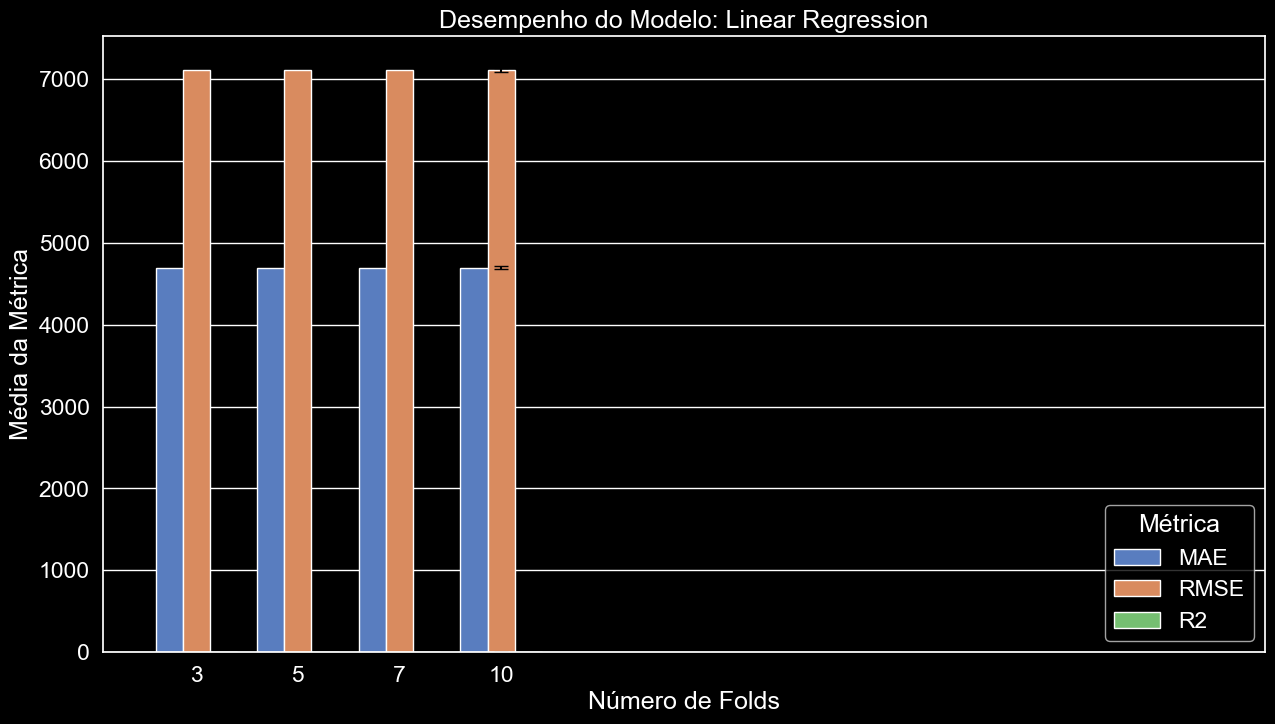

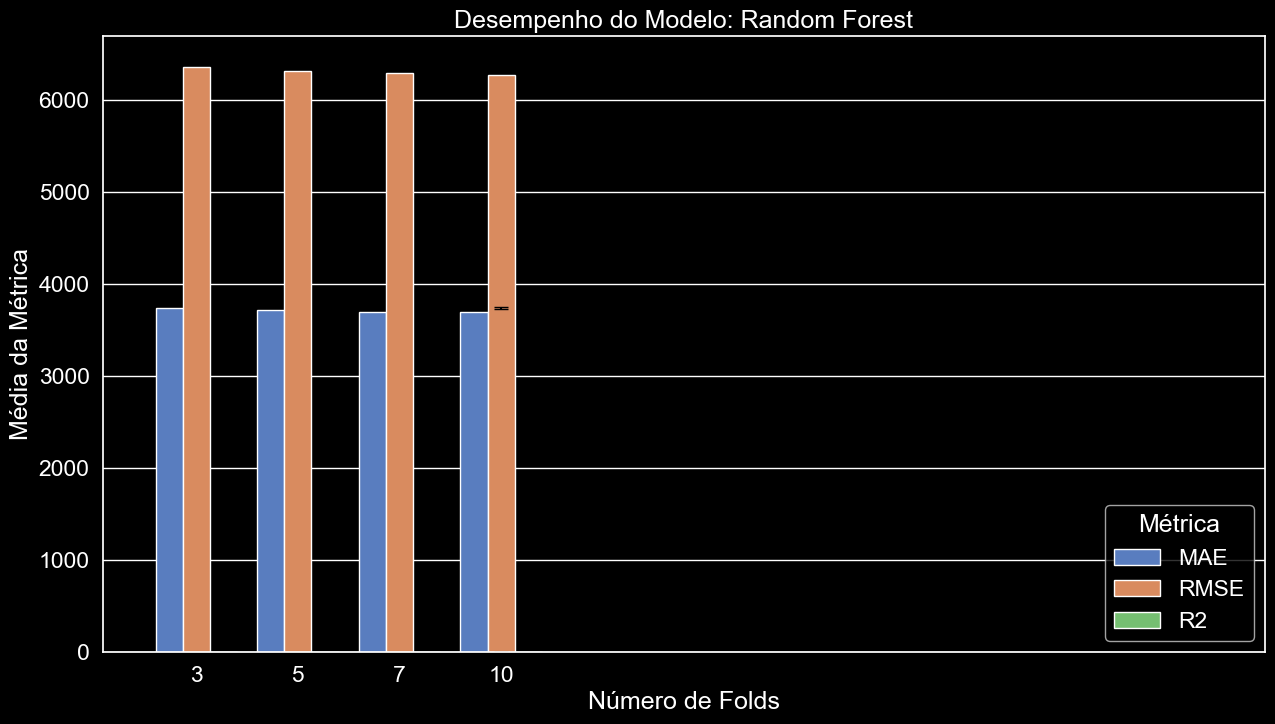

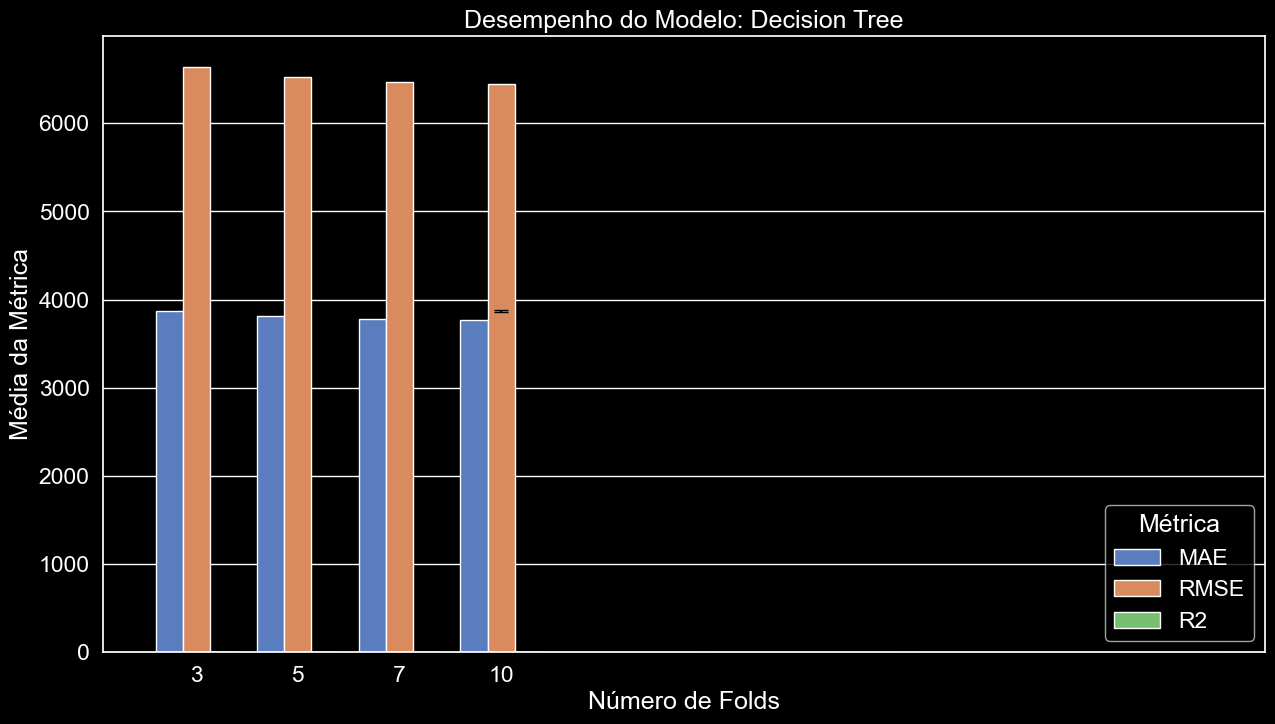

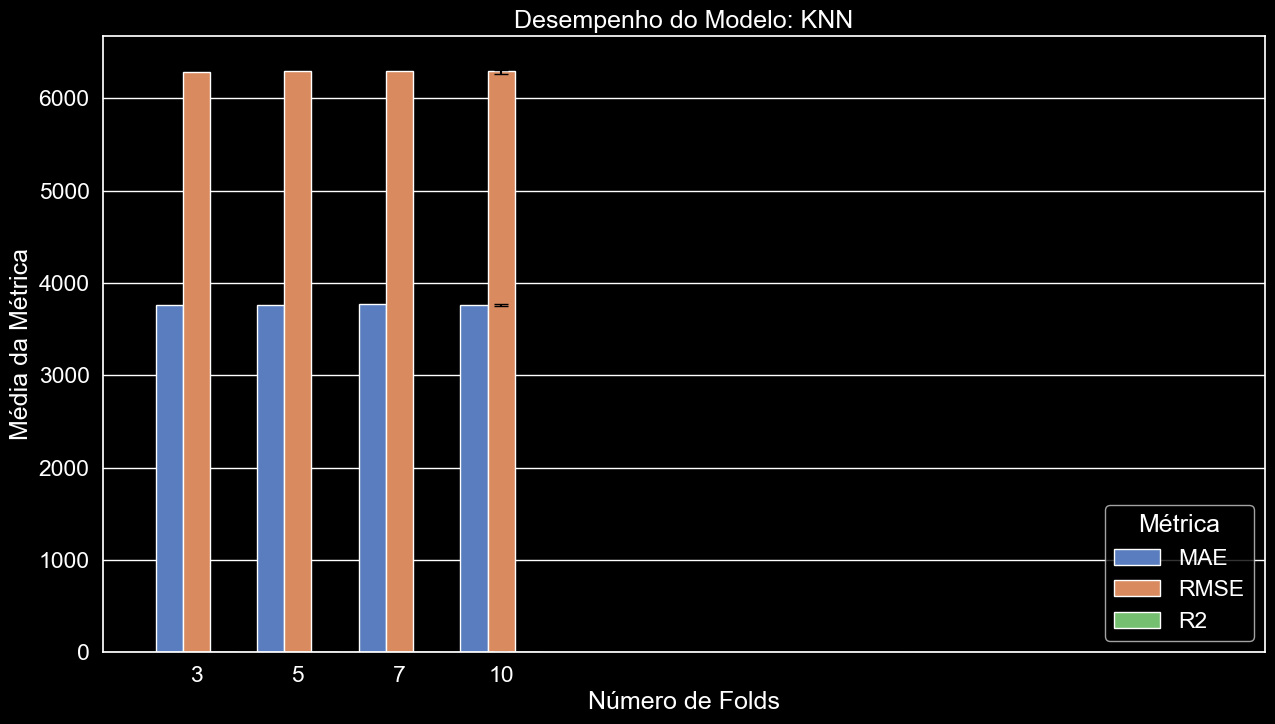

In [ ]:
# Função para plotar gráficos de desempenho
def plotar_desempenho(resultados, nome_modelo):
    resultados_df = pd.DataFrame(columns=['Fold', 'Métrica', 'Média', 'Desvio Padrão'])
    
    for cv, metricas in resultados.items():
        for metrica, resultado in metricas.items():
            # Converter para valores absolutos para MAE e RMSE
            if metrica in ['MAE', 'RMSE']:
                media = abs(resultado['mean_score'])
                desvio = abs(resultado['std_score'])
            else:
                media = resultado['mean_score']
                desvio = resultado['std_score']
            nova_linha = pd.DataFrame({
                'Fold': [cv],
                'Métrica': [metrica],
                'Média': [media],
                'Desvio Padrão': [desvio]
            })
            resultados_df = pd.concat([resultados_df, nova_linha], ignore_index=True)
    
    # Converter a coluna 'Fold' para numérico
    resultados_df['Fold'] = pd.to_numeric(resultados_df['Fold'])
    
    # Criar o gráfico de barras
    plt.figure(figsize=(15, 8))
    sns.barplot(data=resultados_df, x='Fold', y='Média', hue='Métrica', ci=None, palette='muted')
    
    # Adicionar barras de erro
    for metrica in resultados_df['Métrica'].unique():
        metrica_df = resultados_df[resultados_df['Métrica'] == metrica]
        plt.errorbar(metrica_df['Fold'], metrica_df['Média'], yerr=metrica_df['Desvio Padrão'], fmt='none', capsize=5, color='black')
    
    plt.title(f'Desempenho do Modelo: {nome_modelo}')
    plt.xlabel('Número de Folds')
    plt.ylabel('Média da Métrica')
    plt.legend(title='Métrica')
    plt.show()

# Plotar gráficos de desempenho para cada modelo
for nome_modelo, resultados in resultados_iniciais.items():
    plotar_desempenho(resultados, nome_modelo)

fizemos a otimização dos melhores modelos com o GridSeachrCV

In [ ]:
# Definir os parâmetros para GridSearchCV
parametros = {
    "Linear Regression": {"fit_intercept": [True, False]},
    "Random Forest": {'n_estimators': [10, 50, 100]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "Decision Tree": {'max_depth': [None, 10, 20, 30]},
    "KNN": {'n_neighbors': [3, 5, 7]},
    "SVR": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "Ridge": {'alpha': [0.1, 1, 10]}
}

# Função para otimizar os modelos com GridSearchCV
def otimizar_modelo_com_gridsearch(modelo, parametros, X_train_transformed, y_train, folds):
    resultados = {}
    for fold in folds:
        print(f"Otimização para o modelo {nome}:")
        print(f"{fold} folds \n")
        print('-'*50)
        grid_search = GridSearchCV(estimator=modelo, param_grid=parametros, cv=fold, scoring=scorers, refit='R2')
        grid_search.fit(X_train_transformed, y_train)
        resultados[fold] = grid_search.cv_results_
    return resultados

# Otimizar os modelos selecionados
resultados_otimizados = {}
for nome, modelo in modelos.items():
    if nome in parametros:
        resultados_otimizados[nome] = otimizar_modelo_com_gridsearch(modelo, parametros[nome], X_train_transformed, y_train, folds)

Otimização com 3 folds para o modelo Linear Regression - LinearRegression...
Otimização com 5 folds para o modelo Linear Regression - LinearRegression...
Otimização com 7 folds para o modelo Linear Regression - LinearRegression...
Otimização com 10 folds para o modelo Linear Regression - LinearRegression...
Otimização com 3 folds para o modelo Random Forest - RandomForestRegressor...
Otimização com 5 folds para o modelo Random Forest - RandomForestRegressor...
Otimização com 7 folds para o modelo Random Forest - RandomForestRegressor...
Otimização com 10 folds para o modelo Random Forest - RandomForestRegressor...
Otimização com 3 folds para o modelo Decision Tree - DecisionTreeRegressor...
Otimização com 5 folds para o modelo Decision Tree - DecisionTreeRegressor...
Otimização com 7 folds para o modelo Decision Tree - DecisionTreeRegressor...
Otimização com 10 folds para o modelo Decision Tree - DecisionTreeRegressor...
Otimização com 3 folds para o modelo KNN - KNeighborsRegressor...

os resultados otimizados

In [ ]:
# Exibir os resultados otimizados
for nome_modelo, resultados in resultados_otimizados.items():
        print(f"\nResultados otimizados para o modelo {nome_modelo}:")
        for cv, metricas in resultados.items():
            print(f"  {cv} folds:")
            for i in range(len(metricas['mean_test_R2'])):
                print(f"\n Parâmetros: {metricas['params'][i]}\n")
                print(f"MAE: Média = {abs(metricas['mean_test_MAE'][i]):.4f}, Desvio Padrão = {abs(metricas['std_test_MAE'][i]):.4f} \n")
                print(f"RMSE: Média = {abs(metricas['mean_test_RMSE'][i]):.4f}, Desvio Padrão = {abs(metricas['std_test_RMSE'][i]):.4f}\n")
                print(f"R2: Média = {metricas['mean_test_R2'][i]:.4f}, Desvio Padrão = {metricas['std_test_R2'][i]:.4f}\n")


Resultados otimizados para o modelo Linear Regression:
  3 folds:
Parâmetros: {'fit_intercept': True, 'n_jobs': True}
MAE: Média = 4694.4236, Desvio Padrão = 18.8908
RMSE: Média = 7113.3015, Desvio Padrão = 24.9094
R2: Média = 0.9018, Desvio Padrão = 0.0006
Parâmetros: {'fit_intercept': True, 'n_jobs': False}
MAE: Média = 4694.4236, Desvio Padrão = 18.8908
RMSE: Média = 7113.3015, Desvio Padrão = 24.9094
R2: Média = 0.9018, Desvio Padrão = 0.0006
Parâmetros: {'fit_intercept': False, 'n_jobs': True}
MAE: Média = 4693.1215, Desvio Padrão = 18.9484
RMSE: Média = 7113.2857, Desvio Padrão = 24.9794
R2: Média = 0.9018, Desvio Padrão = 0.0006
Parâmetros: {'fit_intercept': False, 'n_jobs': False}
MAE: Média = 4693.1215, Desvio Padrão = 18.9484
RMSE: Média = 7113.2857, Desvio Padrão = 24.9794
R2: Média = 0.9018, Desvio Padrão = 0.0006
  5 folds:
Parâmetros: {'fit_intercept': True, 'n_jobs': True}
MAE: Média = 4695.1807, Desvio Padrão = 21.0142
RMSE: Média = 7113.1474, Desvio Padrão = 31.7607
R

Com base nos resultados apresentados, os melhores hiperparâmetros para cada modelo são:

### *Linear Regression*
- O melhor resultado foi obtido com:
  - *Parâmetros*: {'fit_intercept': False, 'n_jobs': True} (ou False, pois os valores são idênticos)
  - *Melhores métricas*:
    - *MAE*: 4692.7394
    - *RMSE*: 7112.9612
    - *R²*: 0.9018
  - *Número de folds: **10 folds* (melhor equilíbrio entre MAE e RMSE)

### *Decision Tree*
- O melhor resultado foi obtido com:
  - *Parâmetros*: {'max_depth': 10}
  - *Melhores métricas*:
    - *MAE*: 3390.4496
    - *RMSE*: 5745.6410
    - *R²*: 0.9359
  - *Número de folds: **10 folds* (melhor equilíbrio entre MAE e RMSE)

### *KNN*
- O melhor resultado foi obtido com:
  - *Parâmetros*: {'n_neighbors': 7}
  - *Melhores métricas*:
    - *MAE*: 3673.7865
    - *RMSE*: 6150.3500
    - *R²*: 0.9266
  - *Número de folds: **10 folds* (melhor equilíbrio entre MAE e RMSE)

### *Resumo dos melhores hiperparâmetros por modelo:*
| Modelo             | Melhor Parâmetro          | Folds | MAE    | RMSE   | R²    |
|-------------------|--------------------------|-------|--------|--------|-------|
| *Linear Regression* | {'fit_intercept': [False, True]} | 10 | 4692.7394 | 7112.9612 | 0.9018 |
| *Decision Tree* | {'max_depth': 10} | 10 | 3390.4496 | 5745.6410 | 0.9359 |
| *KNN* | {'n_neighbors': 7} | 10 | 3673.7865 | 6150.3500 | 0.9266 |

Esses são os melhores hiperparâmetros considerando as métricas de erro e a quantidade de folds usada na validação cruzada.

# Aperfeiçoamento do Sistema

Como sempre, automatize o que for possível.
1.  Ajuste os hiperparâmetros usando validação cruzada:
    - Trate suas opções de transformação de dados como hiperparâmetros, ainda mais quando você não estiver certo sobre elas (por exemplo, se não tiver certeza se deve substituir os valores ausentes por zeros ou pelo valor mediano, ou apenas dropar as linhas).
    - A menos que haja poucos valores de hiperparâmetros para explorar, prefira o random search em vez do grid search. Se o treinamento for muito longo, você pode preferir uma abordagem de otimização bayesiana (por exemplo, usando processos gaussianos anteriores conforme descrito por Jasper Snoek et al. — https://homl.info/134)
2. Teste os métodos ensemble. Combinar seus melhores modelos geralmente resultará em um melhor desempenho do que executá-los individualmente.
Uma vez que você esteja confiante sobre seu modelo final, meça seu desempenho no conjunto de testes para estimar o erro de generalização.

In [ ]:
# Separando os dados em treino e teste
X = df_exploracao.drop(columns=['price'], axis=1)
y = df_exploracao['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared_df = pd.DataFrame(
    X_train_prepared.toarray(),  # Converte a matriz esparsa em um array denso
    columns=full_pipeline.get_feature_names_out()  # Obtém os nomes das colunas geradas pelo pipeline
)
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared_df = pd.DataFrame(
    X_test_prepared.toarray(),  # Converte a matriz esparsa em um array denso
    columns=full_pipeline.get_feature_names_out()  # Obtém os nomes das colunas geradas pelo pipeline
)

# Definição dos hiperparâmetros otimizados
tuned_lr = LinearRegression(fit_intercept=False, n_jobs=True)
tuned_dt = DecisionTreeRegressor(max_depth=10, random_state=42)
tuned_knn = KNeighborsRegressor(n_neighbors=7)
tuned_sv = SVR(C=10, kernel='rbf')
tuned_ridge = Ridge(alpha=10)


# Criando o ensemble
ensemble = VotingRegressor(
    estimators=[
        ('lr', tuned_lr), 
        ('dt', tuned_dt), 
        ('knn', tuned_knn),
        ('svr', tuned_sv),
        ('ridge', tuned_ridge)
    ]
)

# Treinando o modelo ensemble
ensemble.fit(X_train_prepared_df, y_train)

# Fazendo previsões no conjunto de teste
y_pred = ensemble.predict(X_test_prepared_df)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Exibindo as métricas
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Análise das features mais importantes para o RandomForest
modelo_rf = modelos["Random Forest"].named_steps['model']
importances = modelo_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f in range(X_train_transformed.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")

# Inspeção de instâncias com erro grande
errors = np.abs(y_test - y_pred)
large_errors = errors > np.percentile(errors, 95)
print("Instâncias com grandes erros:")
print(X_test[large_errors])
print(y_test[large_errors])
print(y_pred[large_errors])

MAE: 2637.6186
MSE: 19299056.9490
RMSE: 4393.0692
R²: 0.9626


In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_exploracao.merge(out,left_index=True,right_index=True)

print(result.sample(10))

plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

NameError: name 'y_pred' is not defined